In [1]:
import matplotlib.pyplot as plt
import process_data
import pandas as pd
import numpy as np
from get_log_time import get_log_tags_dataframe, tag_name_to_value
from process_data import get_log_files, get_log_files_dataframe, get_log_tags_dataframe, \
    clean_log_dataframe, add_query_id_node_id_dataframe, get_msg_id_to_batch_id_dict, \
    add_batch_id_to_all_compute, compute_task_times, global_search_udl_times

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload


need to graph all the data collected mate

In [4]:
remote_single_node_data_folder = "/home/nam/workspace/rdma_anns/remote_data/single_node/"
remote_rdma_data_folder = "/home/nam/workspace/rdma_anns/remote_data/rdma/"
 = "/home/nam/workspace/rdma_anns/local_data/"


local duration dataframes

In [5]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [6]:
suffix = ".dat"
log_files = get_log_files(local_data_folder, suffix)
df = get_log_files_dataframe(log_files)

log_tags_df = get_log_tags_dataframe()
tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)

df = clean_log_dataframe(df)
df, abnormal_rows = add_query_id_node_id_dataframe(df)

msg_id_to_batch_id_dict = get_msg_id_to_batch_id_dict(df, tag_fn)
# print(msg_id_to_batch_id_dict)
conflicts = add_batch_id_to_all_compute(df, msg_id_to_batch_id_dict)

roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
    put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
    query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time \
    = compute_task_times(df, tag_fn)

search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
    push_message_time_df = global_search_udl_times(df, tag_fn)

number of existing batch id 352664
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
num_malformed 50379
count 50379
mean:  113.96888584529268
std:  25580.620453214917
90p:   0.0
99p:  0.0
compute query duration from send request to start of serialization of that batch on batching thread
count 50378
mean:  1190.1841031799595
std:  1548.0478340160107
90p:   2722.75
99p:  8247.974999999766
batch serialization time between udls for global search
count 14301
mean:  5.897839311936228
std:  5.208320187666505
90p:   9.5
99p:  16.25
batch sending latency between udls for global search
num_malformed 1
count 14301
mean:  1597.9361932731977
std:  1649.7280324259884
90p:   3647.75
99p:  8116.5
time to complete a put_and_forget
count 14301
mean:  579.1003601146773
std:  783.4198394557303
90p:   951.25
99p:  4140.25
time to transfer messages from cluster messages to to_send
count 11509
mean:  30.00288904335737
std:  25.476532742514348
90p:   45.25
99p:  7

KeyError: 'latency'

In [ ]:
def visualize_dataframe(df, y_column_name,y_label, ax_0 ,ax_1):
    print(df.describe())
    ax_0.scatter(df["timestamp"], df[y_column_name], s = 0.15, alpha = 0.1)
    ax_0.set_xlabel("start timestamp")
    ax_0.set_ylabel(y_label)
    latency = df[y_column_name].to_numpy()
    filtered_latency = latency[~is_outlier(latency)]
    ax_1.hist(filtered_latency, 50)
    ax_1.set_ylabel(y_label)

def visualize_duration_dataframe(df, ax_0, ax_1):
    visualize_dataframe(df, "latency", "us", ax_0, ax_1)

def visualize_extra_dataframe(df, y_label, ax_0, ax_1):
    visualize_dataframe(df, "extra", y_label, ax_0, ax_1)
    

This is the time to complete a function call to the global udl ocdpo_handler

           batch_id       latency     timestamp
count  3.346800e+04  33468.000000  3.346800e+04
mean   9.287408e+18     87.634995  1.756873e+15
std    5.346824e+18    110.783673  2.918914e+06
min    6.333179e+13      9.500000  1.756873e+15
25%    4.651396e+18     43.250000  1.756873e+15
50%    9.286558e+18     57.500000  1.756873e+15
75%    1.394837e+19     73.250000  1.756873e+15
max    1.844671e+19   1318.000000  1.756873e+15


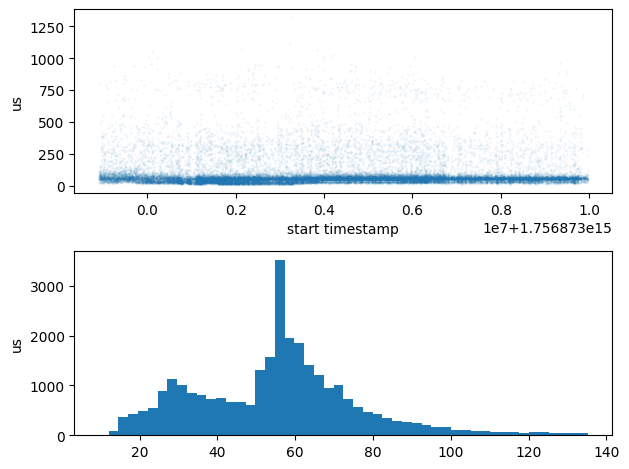

In [67]:
fig_global_udl_handler_time, axes = plt.subplots(2)
visualize_duration_dataframe(global_udl_handler_time_df, axes[0], axes[1])
fig_global_udl_handler_time.tight_layout()
fig_global_udl_handler_time.savefig("global_udl_handler_completion_time.png", dpi=300)

This is the roundtrip latency of the compute tasks

       client_node_id      query_id       node_id        latency     timestamp
count         50707.0  50707.000000  5.070700e+04   50707.000000  5.070700e+04
mean              3.0   4968.625318  4.597477e+06    6837.142387  1.756873e+15
std               0.0   2900.521446  2.924136e+06    7055.625935  3.019433e+06
min               3.0      0.000000  0.000000e+00    1528.250000  1.756873e+15
25%               3.0   2447.000000  2.008534e+06    4030.500000  1.756873e+15
50%               3.0   4953.000000  4.388584e+06    5186.000000  1.756873e+15
75%               3.0   7473.000000  7.043758e+06    7666.250000  1.756873e+15
max               3.0   9999.000000  9.999837e+06  104993.750000  1.756873e+15


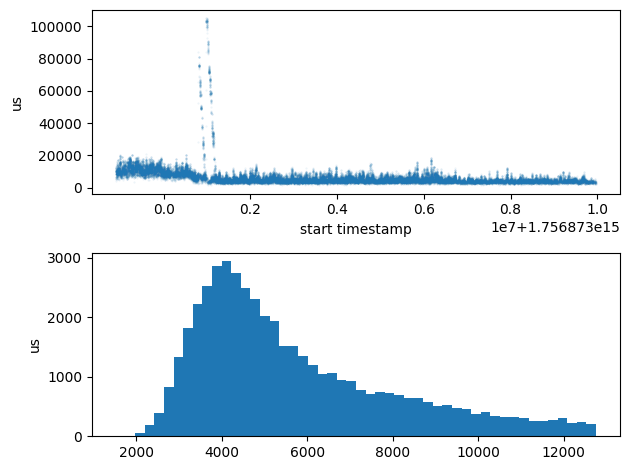

In [68]:
fig_compute_roundtrip_durations, axes = plt.subplots(2)
visualize_duration_dataframe(roundtrip_durations, axes[0], axes[1])
fig_compute_roundtrip_durations.tight_layout()
fig_compute_roundtrip_durations.savefig("compute_roundtrip_durations.png")

           batch_id       latency     timestamp
count  3.346800e+04  33468.000000  3.346800e+04
mean   9.287408e+18   1966.568730  1.756873e+15
std    5.346824e+18   1443.134943  2.919270e+06
min    6.333179e+13      0.000000  1.756873e+15
25%    4.651396e+18    750.750000  1.756873e+15
50%    9.286558e+18   1664.500000  1.756873e+15
75%    1.394837e+19   2960.562500  1.756873e+15
max    1.844671e+19   9863.250000  1.756873e+15


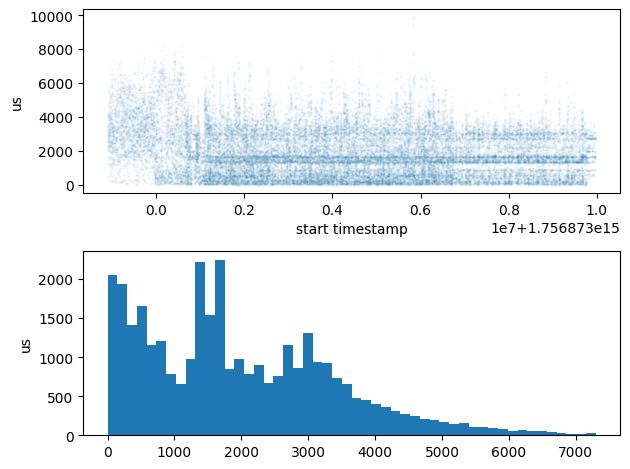

In [69]:
fig_batch_send_latency, axes = plt.subplots(2)
visualize_duration_dataframe(batch_send_latency, axes[0], axes[1])
fig_batch_send_latency.tight_layout()
fig_batch_send_latency.savefig("batch_send_latency.png")

           tag     timestamp  client_node_id        msg_id         extra  \
count  33468.0  3.346800e+04    3.346800e+04  3.346800e+04  33468.000000   
mean   20220.0  1.756873e+15    1.844674e+19  9.287408e+18    480.456077   
std        0.0  2.918914e+06    0.000000e+00  5.346824e+18    444.375419   
min    20220.0  1.756873e+15    1.844674e+19  6.333179e+13     66.000000   
25%    20220.0  1.756873e+15    1.844674e+19  4.651396e+18    186.000000   
50%    20220.0  1.756873e+15    1.844674e+19  9.286558e+18    318.000000   
75%    20220.0  1.756873e+15    1.844674e+19  1.394837e+19    616.000000   
max    20220.0  1.756873e+15    1.844674e+19  1.844671e+19   5140.000000   

       query_id  node_id      batch_id  
count       0.0      0.0  3.346800e+04  
mean        NaN      NaN  9.287408e+18  
std         NaN      NaN  5.346824e+18  
min         NaN      NaN  6.333179e+13  
25%         NaN      NaN  4.651396e+18  
50%         NaN      NaN  9.286558e+18  
75%         NaN      NaN  1.

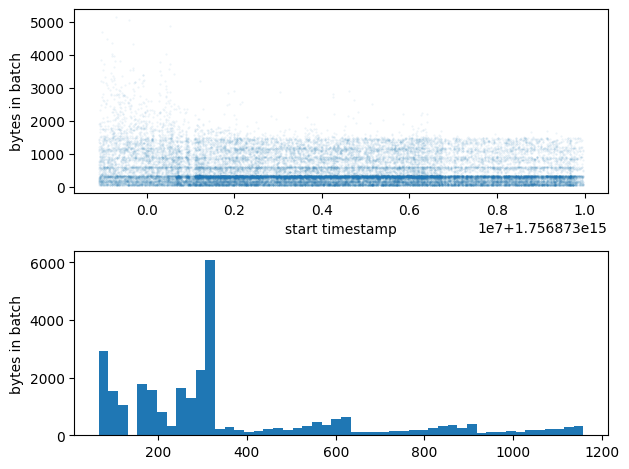

In [70]:
fig_num_bytes_batch, axes = plt.subplots(2)
visualize_extra_dataframe(global_udl_handler_bytes_df, "bytes in batch", axes[0], axes[1])
fig_num_bytes_batch.tight_layout()
fig_num_bytes_batch.savefig("num_bytes_in_batch.png")

now we need to graph everything in a grid, need the main suspects of the latency: 
- roundtrip durations
- batch send latency
- time for when compute query is pushed to queue to when its popped off for compute
- Time from putting a compute query/result onto the batching thread queue to it being serialized
- udl handler times



       client_node_id      query_id       node_id        latency     timestamp
count         50707.0  50707.000000  5.070700e+04   50707.000000  5.070700e+04
mean              3.0   4968.625318  4.597477e+06    6837.142387  1.756873e+15
std               0.0   2900.521446  2.924136e+06    7055.625935  3.019433e+06
min               3.0      0.000000  0.000000e+00    1528.250000  1.756873e+15
25%               3.0   2447.000000  2.008534e+06    4030.500000  1.756873e+15
50%               3.0   4953.000000  4.388584e+06    5186.000000  1.756873e+15
75%               3.0   7473.000000  7.043758e+06    7666.250000  1.756873e+15
max               3.0   9999.000000  9.999837e+06  104993.750000  1.756873e+15
           batch_id       latency     timestamp
count  3.346800e+04  33468.000000  3.346800e+04
mean   9.287408e+18   1966.568730  1.756873e+15
std    5.346824e+18   1443.134943  2.919270e+06
min    6.333179e+13      0.000000  1.756873e+15
25%    4.651396e+18    750.750000  1.756873e+15
5

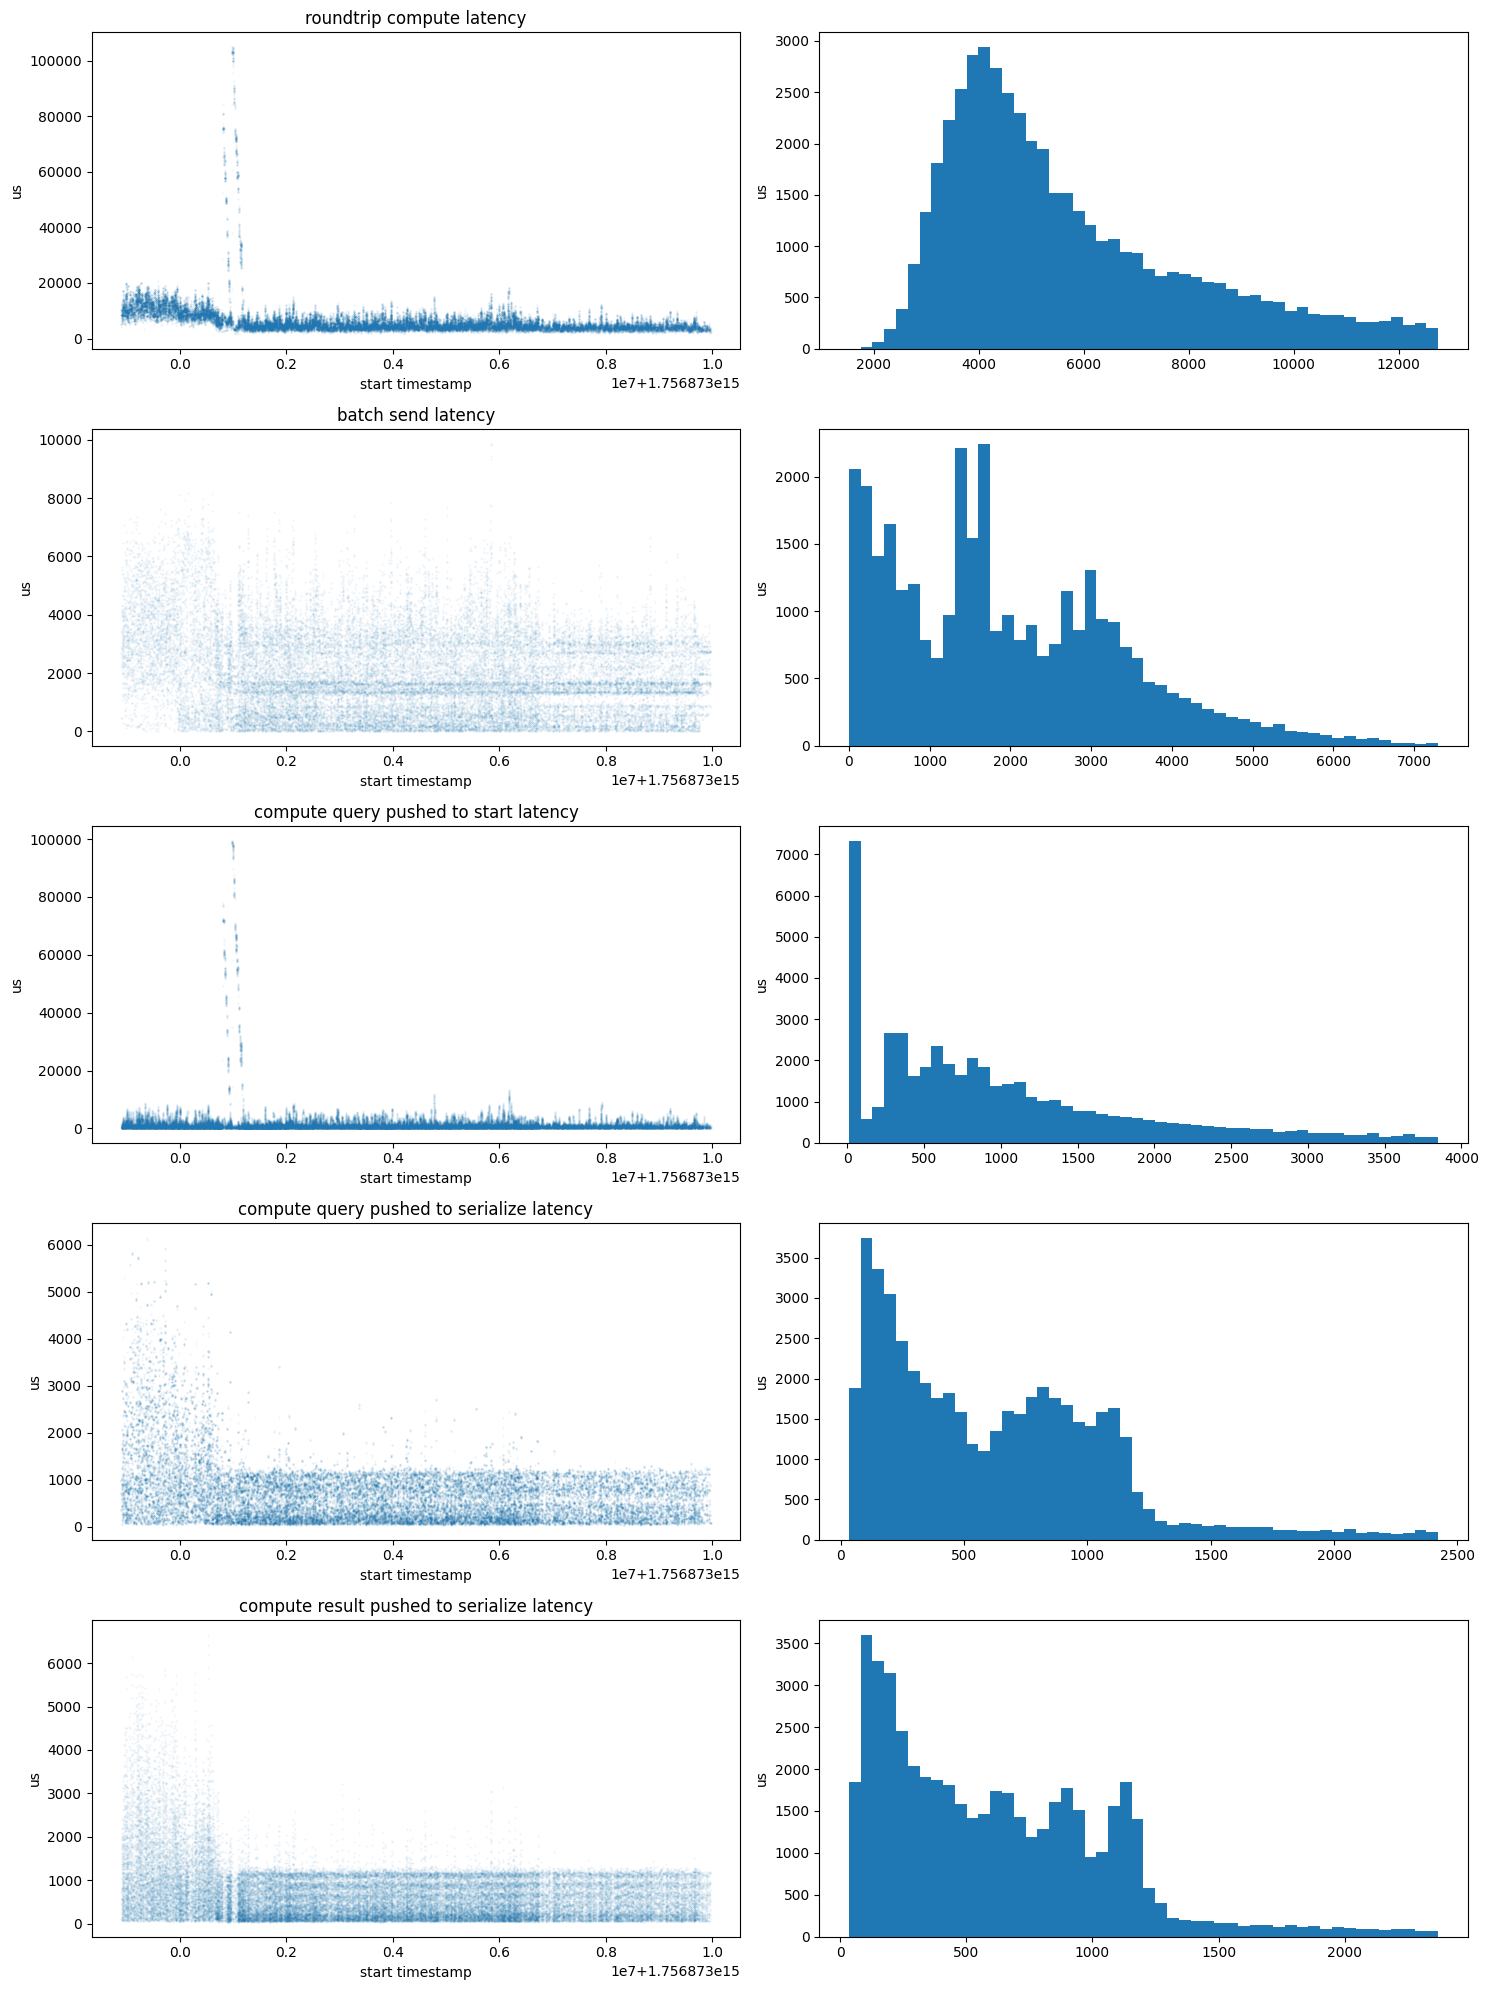

In [88]:
summary_fig, axes = plt.subplots(5, 2)
summary_fig.set_size_inches(15, 20) 
axes[0, 0].set_title("roundtrip compute latency")
visualize_duration_dataframe(roundtrip_durations, axes[0, 0], axes[0, 1])
axes[1, 0].set_title("batch send latency")
visualize_duration_dataframe(batch_send_latency, axes[1, 0], axes[1, 1])
axes[2, 0].set_title("compute query pushed to start latency")
visualize_duration_dataframe(query_pushed_to_start_time, axes[2, 0], axes[2, 1])
axes[3, 0].set_title("compute query pushed to serialize latency")
visualize_duration_dataframe(query_send_to_serialize_durations, axes[3, 0], axes[3, 1])
axes[4, 0].set_title("compute result pushed to serialize latency")
visualize_duration_dataframe(compute_result_to_serialize_time, axes[4, 0], axes[4, 1])
summary_fig.tight_layout()
summary_fig.savefig("grid.png", dpi=300)